# Importing necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4855, 0.4568, 0.4069], std=[0.2319, 0.2190, 0.2058])
])

# loading Dataset

In [6]:
dataset = datasets.ImageFolder(root='/home/lahari/Downloads/training_set', transform=transform)

def augmentation(dataset, n):
    augmented_images = []
    index = {i: [] for i in range(len(dataset.classes))}
    
    for i, (_, label) in enumerate(dataset):
        index[label].append(i)

    for label, i in index.items():
        num = len(i)
        req = n - num
        for _ in range(req):
            random_index = random.choice(i)  
            img, _ = dataset[random_index]  

            if isinstance(img, torch.Tensor):
                img = transforms.ToPILImage()(img)
            augmented_image = transform(img)  
            augmented_images.append((augmented_image, label))
    
    return augmented_images


In [14]:
n = 2000  
augmented_images = augmentation(dataset, n)

augmented_dataset = ConcatDataset([dataset, augmented_images])

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(augmented_dataset))
val_size = int(0.15 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size - val_size

train, val, test = torch.utils.data.random_split(augmented_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

# CNN Model

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.7)
        self.ann_layer1 = nn.Linear(48 * 28 * 28, 120)  
        self.ann_layer2 = nn.Linear(120, 60)
        self.ann_layer3 = nn.Linear(60, 4)  
        
    def forward(self, x):
        x = F.relu(self.conv_layer1(x))
        x = self.pool(x)
        x = F.relu(self.conv_layer2(x))
        x = self.pool(x)
        x = F.relu(self.conv_layer3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) 
        
        x = F.relu(self.ann_layer1(x))
        x = self.dropout(x)
        x = F.relu(self.ann_layer2(x))
        x = self.dropout(x)
        
        x = self.ann_layer3(x)
        
        return x

In [18]:
model = CNN().to(device)  
print(summary(model))

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)  
criterion = nn.CrossEntropyLoss()
Loss = []
Validation_loss = []
num_of_epochs = 25
for epoch in range(num_of_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    Loss.append(loss.item())
    Validation_loss.append(val_loss)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

CNN(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
  (ann_layer1): Linear(in_features=37632, out_features=120, bias=True)
  (ann_layer2): Linear(in_features=120, out_features=60, bias=True)
  (ann_layer3): Linear(in_features=60, out_features=4, bias=True)
)
Epoch 1, Loss: 1.3371, Val Loss: 1.3323
Epoch 2, Loss: 1.1843, Val Loss: 1.1916
Epoch 3, Loss: 1.3073, Val Loss: 0.8223
Epoch 4, Loss: 0.7553, Val Loss: 0.5287
Epoch 5, Loss: 0.5469, Val Loss: 0.2983
Epoch 6, Loss: 0.4104, Val Loss: 0.2370
Epoch 7, Loss: 0.5274, Val Loss: 0.1942
Epoch 8, Loss: 0.9694, Val Loss: 0.1936
Epoch 9, Loss: 0.3091, Val Loss: 0.1445
Epoch 10, Loss: 0.3415, Val Loss: 0.1238
Epoch 11, L

In [20]:
torch.save(model.state_dict(), 'cnn_model.pth')
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
accuracy = 100 * correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

Test Loss: 0.1538, Accuracy: 94.17%


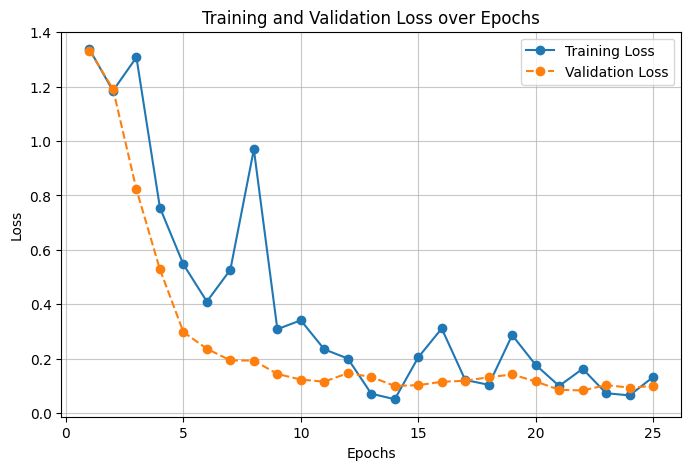

In [35]:

epochs = list(range(1,26))


plt.figure(figsize=(8, 5))
plt.plot(epochs, Loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, Validation_loss, label='Validation Loss', marker='o', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.grid(alpha = 0.7)
plt.legend()
plt.show()

In [ ]:
model = CNN().to(device)  
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)  
criterion = nn.MSELoss()
Loss = []
Validation_loss = []
num_of_epochs = 10
for epoch in range(num_of_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    Loss.append(loss.item())
    Validation_loss.append(val_loss)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

# Testing for some samples directly given

In [28]:
from PIL import Image
from pdf2image import convert_from_path

In [29]:
model = CNN() 
model.load_state_dict(torch.load('cnn_model.pth'))  
model.eval()  

/tmp/ipykernel_28209/2298286353.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_model.pth'))


CNN(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
  (ann_layer1): Linear(in_features=37632, out_features=120, bias=True)
  (ann_layer2): Linear(in_features=120, out_features=60, bias=True)
  (ann_layer3): Linear(in_features=60, out_features=4, bias=True)
)

In [30]:
def extract_images_from_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    return images

In [31]:
def test_image_or_pdf(file_path):
    if file_path.lower().endswith('.pdf'):
        images = extract_images_from_pdf(file_path)
        predictions = []
        
        for image in images:
            image = image.convert('RGB') 
            image = transform(image) 
            image = image.unsqueeze(0)  
            image = image.to(device) 
            with torch.no_grad():
                output = model(image)
                _, predicted = torch.max(output.data, 1) 
                predictions.append(predicted.item())
        
        return predictions  

    else:
        image = Image.open(file_path).convert('RGB')  
        image = transform(image) 
        image = image.unsqueeze(0)  
        image = image.to(device)  

        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output.data, 1)  
        return predicted.item()  


In [34]:
file_path = '/home/lahari/Downloads/check_code.pdf'  
if file_path.lower().endswith('.pdf'):
    predicted_classes = test_image_or_pdf(file_path)
    for idx, predicted_class in enumerate(predicted_classes):
        if predicted_class == 0: 
            print(f'Page {idx + 1}: {predicted_class} : Aadhar')
        elif predicted_class == 1: 
            print(f'Page {idx + 1}: {predicted_class} : Driving License of Australia')
        elif predicted_class == 2: 
            print(f'Page {idx + 1}: {predicted_class} : IITH ID Card')
        elif predicted_class == 3: 
            print(f'Page {idx + 1}: {predicted_class} : PAN Card')
else:
    predicted_class = test_image_or_pdf(file_path)
    if predicted_class == 0: 
        print(f'{predicted_class} : Aadhar')
    elif predicted_class == 1: 
        print(f'{predicted_class} : Driving License of Australia')
    elif predicted_class == 2: 
        print(f'{predicted_class} : IITH ID Card')
    elif predicted_class == 3: 
        print(f'{predicted_class} : PAN Card')


Page 1: 0 : Aadhar
Page 2: 3 : PAN Card
Page 3: 2 : IITH ID Card
Page 4: 0 : Aadhar


- Except for first image remaining are classified because of the brightness